In [1]:
### IMPORT SCIENTIFIC LIBRARIES ###
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.optimize import curve_fit
import importlib

import matplotlib.pyplot as plt
#import seaborn as sns
plt.rcParams['font.size'], plt.rcParams['axes.labelsize'] = 14, 18
#%matplotlib widget

from tqdm import tqdm
import io, sys, os


import sys
sys.path.append('../SCRIPTS/XPCS_library/')

import ID10_tools as ID10
from ID10_tools import Nx, Ny, Npx
importlib.reload(ID10)
ID10.set_version('v2')

import XPCS_tools as XPCS
from XPCS_tools import E2lambda, lambda2E, theta2Q, Q2theta, decorelation_f
importlib.reload(XPCS)
XPCS.set_beamline('ID10')

import COSMICRAY_tools as COSMIC
importlib.reload(COSMIC)
COSMIC.set_beamline('ID10')

# RAW FOLDER PATH
raw_folder = '../RAW_DATA/'
masks_folder = '../masks/'

# EXPERIMENTAL VARIABLES
XPCS.set_expvar(1350, 1400, 7)
ID10.Nfmax_dense_file = 2000
ID10.Nfmax_sparse_file = 5000

## Load/create masks

### e4m_mask & e4m_htmask

In [2]:
e4m_htmask = np.load(masks_folder+'e4m_htmask_copper_foil_30um_1_1'+'.npy')
e4m_mask = np.load(masks_folder+'e4m_mask'+'.npy')

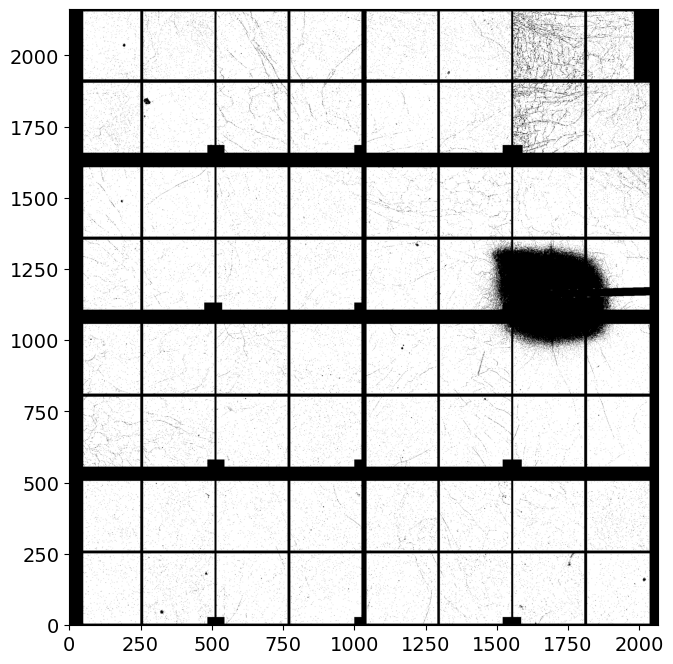

In [3]:
plt.figure(figsize=(8, 8))
plt.imshow((e4m_mask*e4m_htmask).reshape(Nx,Ny), cmap='gray', origin='lower')

### Beamstop mask & Q mask

#### Beamstop mask
Using a random scan in GeO2_6, because we are not changing the measurement configuration

In [4]:
#######################################
sample_name = 'GeO2_6'
Ndataset = 1
Nscan =12
Nfi, Nff = 0, 1000
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),3)

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=1, )

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/1 loops)
Done!
Concatenating vectors ...
Done!
	 | Sparse array loaded from ../RAW_DATA/GeO2_6/GeO2_6_0001/scan0012/
	 | Shape:       (1000, 4471016)
	 | Sparsity:     3.8e-03
	 | Memory usage (scipy.csr_array): 0.192 GB (np.array usage: 16.656 GB)


################################################################################
Maximum count in the hull run -> 4689
# of pixels above Ith_high treshold ->  75 pixels (of 4471016 => 0.0 %)
################################################################################



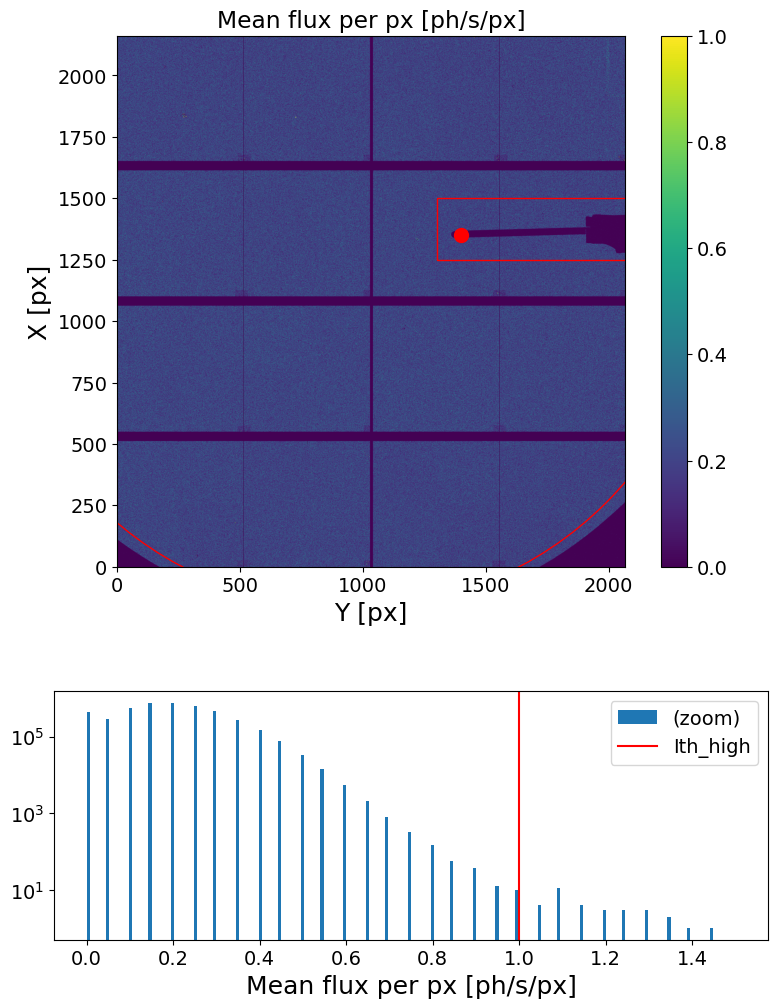

In [5]:
geom = [{'geom':'Rectangle', 'x0':1250, 'y0':1300, 'xl':250, 'yl':1950, 'inside':False},
        {'geom':'Circle', 'Cx':1300, 'Cy':950, 'r':1470, 'inside':True}, 
        ]
XPCS.gen_plots4mask(e4m_data, itime, Ith_high=1, Nff=10000, mask_geom=geom,)

#################################################
Masked area =  93.74594052000708 %
#################################################



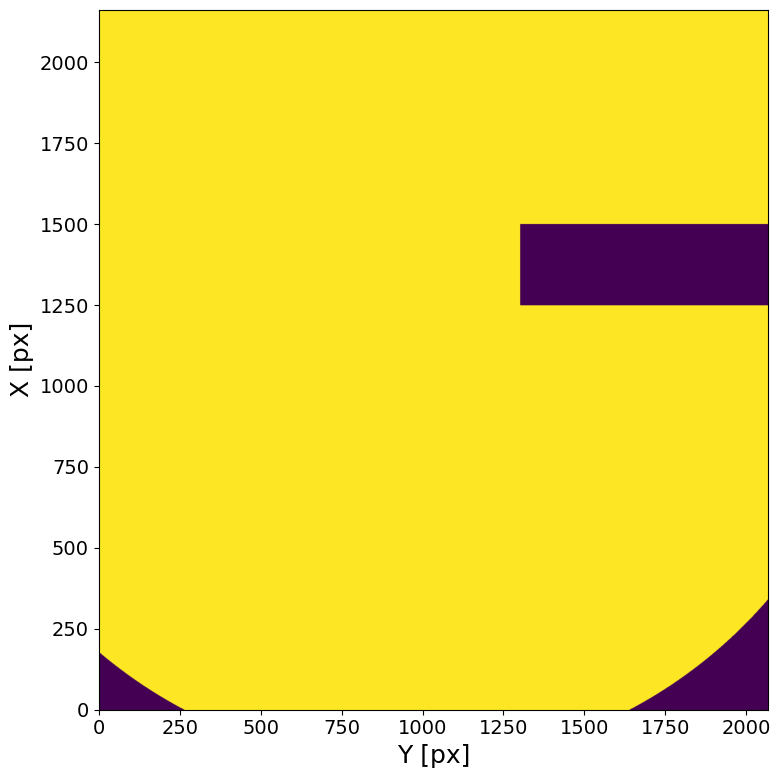

In [6]:
bs_mask = XPCS.gen_mask(e4m_data, itime, e4m_mask=None, mask_geom=geom)

#### Qmask

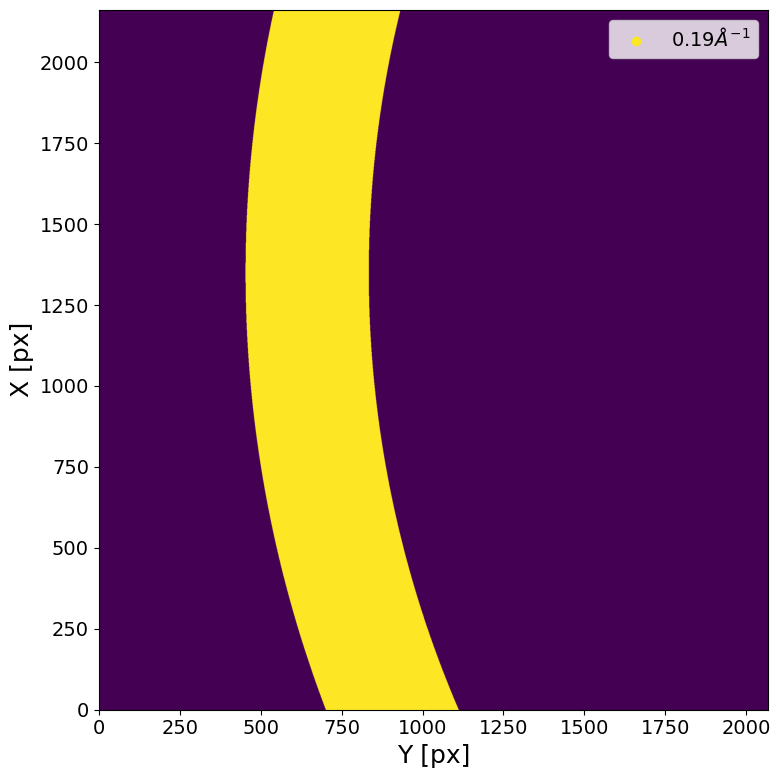

In [7]:
Qmask = XPCS.gen_Qmask(Ei, theta, .19, .01)

### The final mask

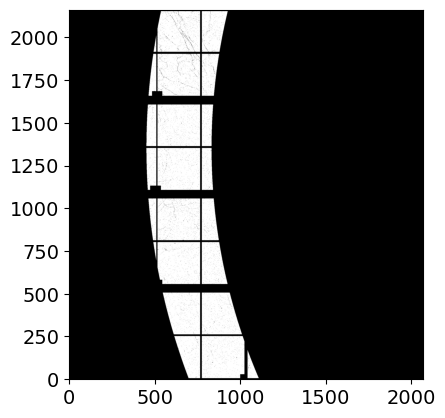

In [8]:
mask4test = e4m_mask*e4m_htmask*bs_mask*Qmask
np.save('mask4test'+'.npy', mask4test)

plt.imshow(mask4test.reshape(Nx,Ny), cmap='gray', origin='lower')

## Load Develpemenrt test data

In [9]:
#######################################
sample_name = 'GeO2_3_415C'
Ndataset = 1
Nscan = 4
sample_name = 'GeO2_6'
Ndataset = 1
Nscan =11
Nfi, Nff =  None, None
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=60, )
e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=3)

#############################
command = mtimescan 0.02 1 15000
Ei = 9.699998837562536
itime = 0.020101
theta = 1.7500000000000004
Q = 0.15
#############################

Loading sparse array ...


	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/3 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/3 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/3 loops)
Done!
Concatenating vectors ...
Done!
	 | Sparse array loaded from ../RAW_DATA/GeO2_6/GeO2_6_0001/scan0011/
	 | Shape:       (15000, 4471016)
	 | Sparsity:     3.7e-03
	 | Memory usage (scipy.csr_array): 2.781 GB (np.array usage: 249.837 GB)
Filtering gamma ray signal (i.e. signals over treshold) ...
Done! (elapsed time = 1.58 s)
Removing gamma ray signal (set 0s) ...
Done! (elapsed time = 1.75 s)


### Intensity profile

In [10]:
####################
Lbin = 1
Nstep = 100
mask = mask4test
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask4test, Lbin=Lbin, Nstep=Nstep)

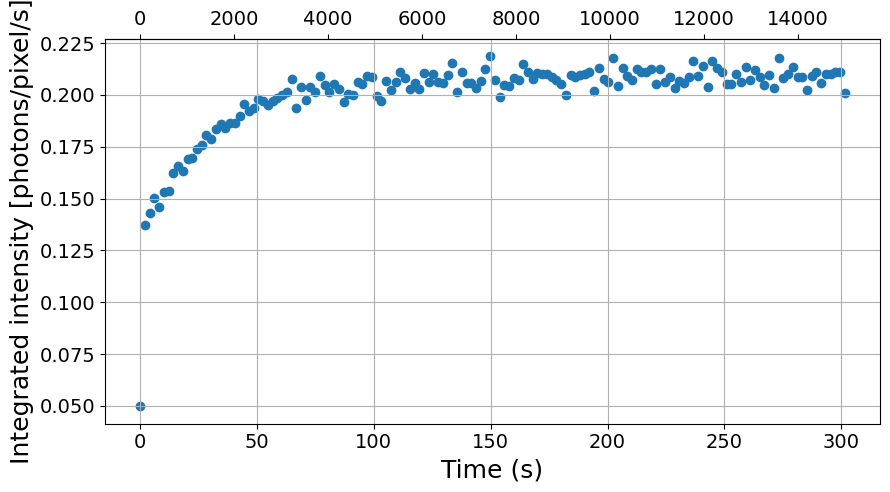

In [11]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')

plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
#plt.xscale('log')
#plt.xlim(1e-2, 1)
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
plt.grid()

## Brand new Multitau algorithm

In [15]:
##### INPUTS #####
e4m_data = e4m_data
mask = mask4test
Nfi = 0
Nff = 2**13
sparse_depth = 10
dense_depth = 13

G2tmt = XPCS.get_G2tmt_4sparse(e4m_data, sparse_depth, dense_depth=dense_depth, mask=mask, Nfi=Nfi, Nff=Nff)

Loading frames ...
Done! (elapsed time = 2.59 s)
Masking data ...
Done! (elapsed time = 2.14 s)
	 | 8192 frames X 710667 pixels
	 | sparsity = 3.91e-03
	 | memory usage (sparse.csr_array @ float32) = 0.254 GB
Computing sparse multitau G2t...


100%|██████████| 8/8 [00:02<00:00,  3.57it/s]


Done! (elapsed time = 2.24 s)
Computing dense multitau G2t...


100%|██████████| 3/3 [00:00<00:00, 186.78it/s]

Done! (elapsed time = 0.07 s)


### How the hell do I plot this???

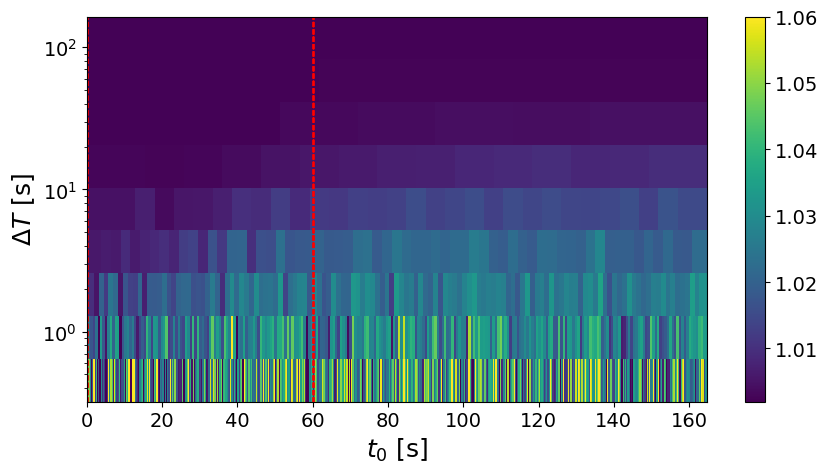

In [ ]:
vmin, vmax = 1.002, 1.06
yscale = 'log2' #'log' / 'lin' / 'log2'
lower_mt = 4
linewidth = 0.2

XPCS.plot_G2tmt(G2tmt, itime, vmin, vmax, yscale='log', lower_mt=lower_mt, borders=False, vlines=[0, 60], filter_layer=0)

Text(0, 0.5, 'dg2')

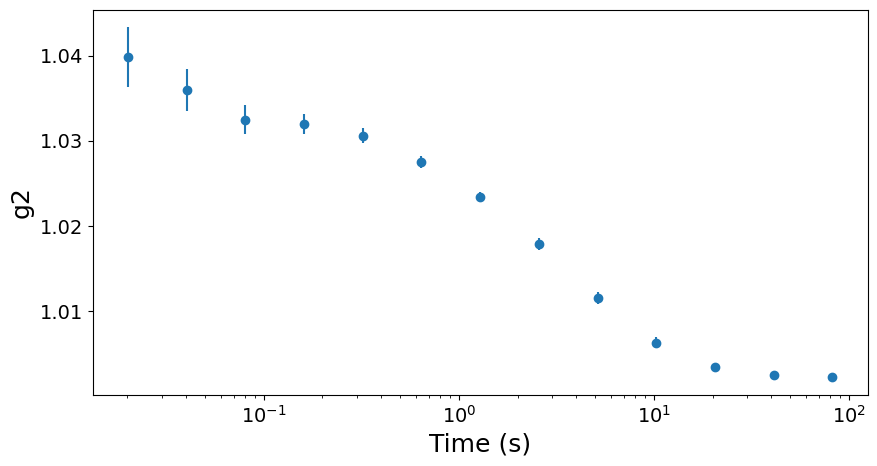

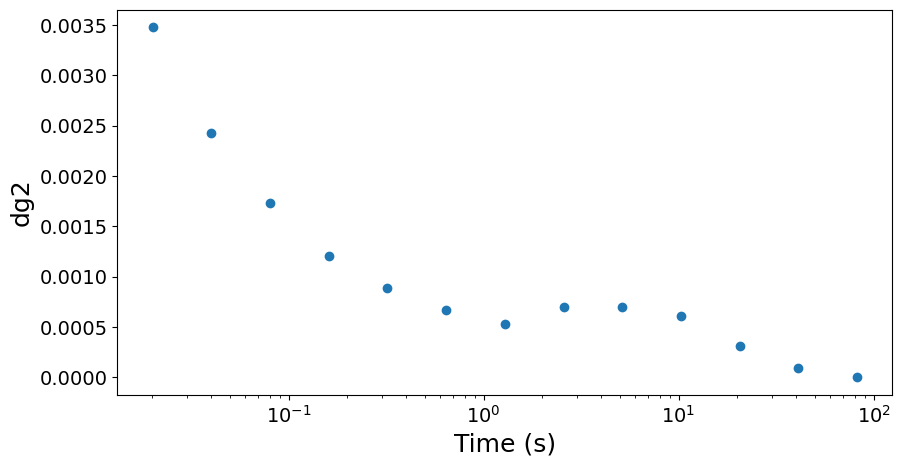

In [113]:
t_g2mt, g2mt, dg2mt = XPCS.get_g2mt(itime, G2tmt)

plt.figure(figsize=(10,5))
plt.errorbar(t_g2mt, g2mt, yerr=dg2mt, fmt='o', label='g2')
plt.xscale('log')
plt.xlabel('Time (s)')
plt.ylabel('g2')

plt.figure(figsize=(10,5))
plt.scatter(t_g2mt, dg2mt, label='dg2')
plt.xscale('log')
plt.xlabel('Time (s)')
plt.ylabel('dg2')

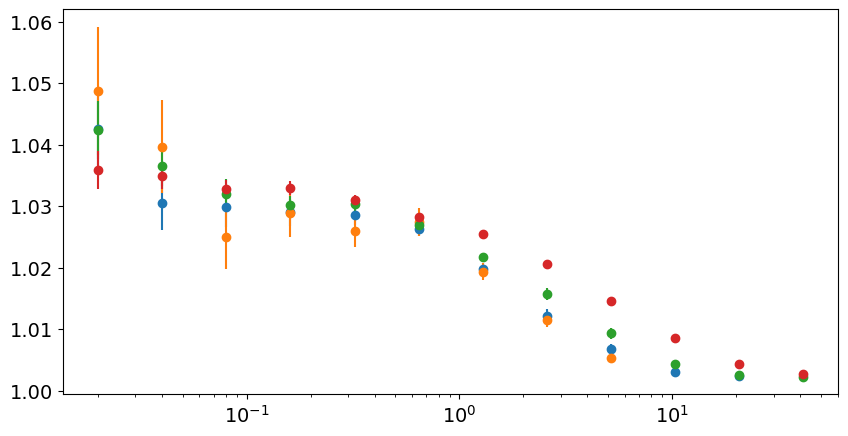

In [67]:
cut1 = XPCS.cut_G2tmt(itime, G2tmt, 0, 60)
cut2 = XPCS.cut_G2tmt(itime, G2tmt, 20, 40)
cut3 = XPCS.cut_G2tmt(itime, G2tmt, 0, 100)
cut4 = XPCS.cut_G2tmt(itime, G2tmt, 60, None)

plt.figure(figsize=(10,5))
t_g2mt, g2mt, dg2mt = XPCS.get_g2mt(itime, cut1)
plt.errorbar(t_g2mt, g2mt, yerr=dg2mt, fmt='o', label='g2')
t_g2mt, g2mt, dg2mt = XPCS.get_g2mt(itime, cut2)
plt.errorbar(t_g2mt, g2mt, yerr=dg2mt, fmt='o', label='g2')
t_g2mt, g2mt, dg2mt = XPCS.get_g2mt(itime, cut3)
plt.errorbar(t_g2mt, g2mt, yerr=dg2mt, fmt='o', label='g2')
t_g2mt, g2mt, dg2mt = XPCS.get_g2mt(itime, cut4)
plt.errorbar(t_g2mt, g2mt, yerr=dg2mt, fmt='o', label='g2')

plt.xscale('log')

## Standar Method

In [ ]:
###################
Lbin = None
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t(e4m_data, mask=mask4test, Nfi=Nfi, Nff=Nff, Lbin=None)
t, g2 = XPCS.get_g2(itime*Lbin, G2t, cython=False)

Loading frames ...


Done! (elapsed time = 2.2 s)
Masking data ...
Done! (elapsed time = 4.47 s)
	 | 14999 frames X 710667 pixels
	 | sparsity = 4.04e-03
	 | memory usage (sparse.csr_array @ float32) = 0.481 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 1.68 s)
	 | 14999 X 14999 squared matrix
	 | memory usage (np.array @ float32) = 0.838 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.09 s)

Computing g2...
Done! (elapsed time = 0.81 s)



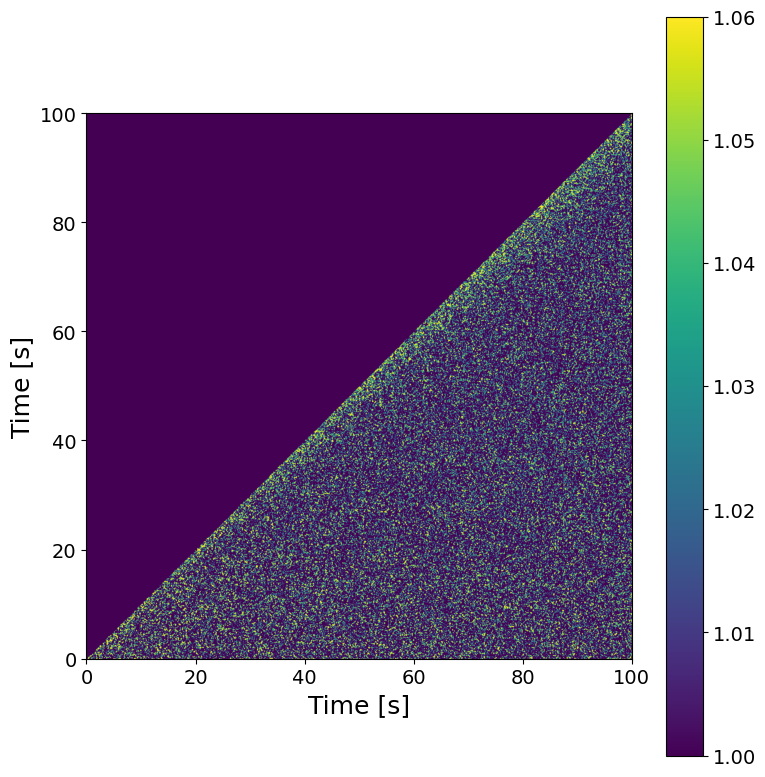

In [ ]:
############################
t1, t2 = 0, 100
vmin, vmax = 1.0, 1.06
############################
XPCS.plot_G2t(G2t, vmin, vmax, itime=itime, t1=t1, t2=t2, sigma_filter=3)

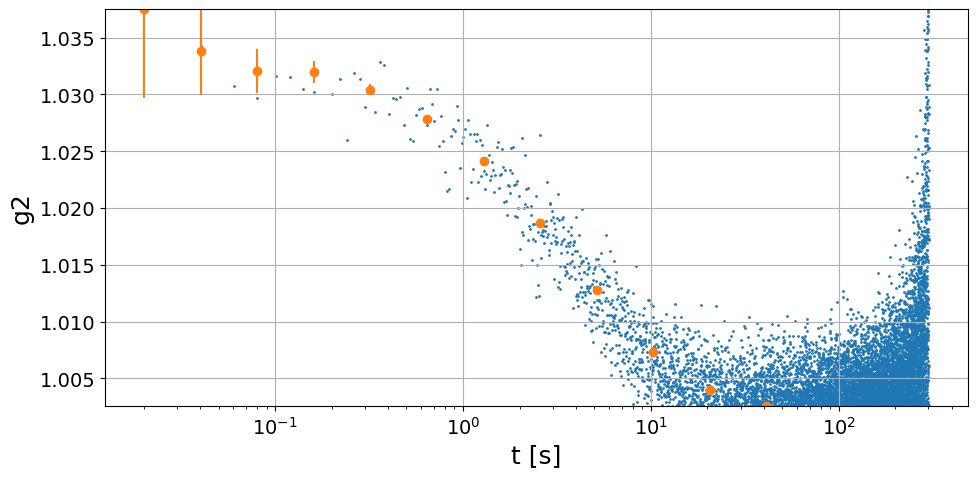

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(t, g2, s=1,)
plt.errorbar(t_g2mt, g2mt, yerr=dg2mt, fmt='o', c='C1')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(g2mt.min(), g2mt.max())
plt.grid()
plt.tight_layout()
plt.show()